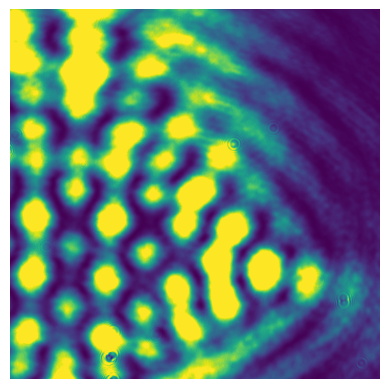

In [1]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
def mkdir(path):
	folder = os.path.exists(path)
	if not folder:                   
		os.makedirs(path)    

from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.01) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner
#images = cam.grab(10) # grab 10 frames

i=0
while i<= 0:
    #A = np.array([[0],[0],[0],[0],[0]], dtype=np.int32)
    A = np.random.randint(low=0,high=2000,size=(5,1), dtype=np.int32)   # range form 0 to 3000
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(0.1) 
    fig_name = 'pwm='+str(int(A[0]))+'-'+str(int(A[1]))+'-'+str(int(A[2]))+'-'+str(int(A[3]))+'-'+str(int(A[4])) +'-'+str(int(i))
    image_array = cam.grab(1)    # grab 1 frame
    image_array=np.array(image_array)
    image_array=image_array.squeeze()
    image = plt.imshow(image_array)
    
    # Display the image without axes
    plt.axis('off')
    plt.imshow(image_array)  # Set the desired colormap if needed

    # Save the image without axes
#     plt.savefig('image_without_axes.png', bbox_inches='tight', pad_inches=0)
    plt.savefig(r'C:\Users\plasma\Desktop\m1\{fig_name}.png'.format(fig_name=fig_name))  # Save the plot
    i=i+1
#can use this to add aberration or add it on pi,see pi_control.py file

In [2]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)
def get_quality_number(images):  
 #gaussian fit at centroid with box range +-5
    x=np.linspace(0,1000,1000)

    [m,n]=np.where(image_array==np.max(image_array))
    mode_info_m = stats.mode(m)  ##col

    mode_info_n = stats.mode(n) ##row

    a=int(mode_info_m[0])
    b=int(mode_info_n[0])
    c=5 #box half-thickness
    y_x=0

    for j in range (a-c,a+c):
        y_x=y_x+image_array[j,:]/100 #tricky here since if this number is >255 it becomes 0.
    y_x=(y_x)/c*100

    y_y=0

    for j in range (b-c,b+c):
        y_y=y_y+image_array[:,j]/100
    y_y=((y_y)/c)*100

    popt_x, pcov_x = optimize.curve_fit(gaussian, x, y_x+1,maxfev=500000) # tricky here!!!!! y_x+1
    fitted_y_x=popt_x[0] * np.exp(-((x - popt_x[1]) / 4 / popt_x[2])**2)
    a_x=r2_score(y_x,fitted_y_x)
    popt_y, pcov_y = optimize.curve_fit(gaussian, x, y_y+1,maxfev=500000) # same here!!!! y_y+1
    fitted_y_y=popt_y[0] * np.exp(-((x - popt_y[1]) / 4 / popt_y[2])**2)
    a_y=r2_score(y_y,fitted_y_y)

    s0=abs(a_x*a_y)
    Score=s0
    return Score   

# get_quality_number(image_array)

In [4]:
from skopt import gp_minimize
import pygad
import laserbeamsize as lbs

# def get_quality_number(image_array):
#     x, y, dx, dy, phi = lbs.beam_size(image_array)
#     Ellipticity = min(dx, dy) / max(dx, dy)
#     threshold_up_area = (image_array >= np.max(image_array) / 10) + 0  # define a threshold area
#     total_pixel = image_array.shape[0] * image_array.shape[1]
#     dispersion = total_pixel / np.sum(threshold_up_area)
#     quality_number = dispersion * Ellipticity
#     return quality_number


def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

# def objective(solution):
#     A = np.array([[solution[0]], [solution[1]], [solution[2]], [solution[3]], [solution[4]]])
#     with open('PWM_test.csv', 'w', newline='') as file:
#         mywriter = csv.writer(file, delimiter=',')
#         mywriter.writerows(A)
#     time.sleep(0.1)
#     cam.set_roi(0, 1000, 0, 1000)  # set ROI
#     image = cam.grab(1)    # grab 1 frame
#     image=np.array(image)
#     image=image.squeeze()
#     quality_number = get_quality_number(image)
#     score = -quality_number
#     return score

# bounds = [(0, 4095)] * 5  # Example bounds for 5 PWM values

# # Modify the following parameters as per your requirements
# n_calls = 50  # Number of iterations
# n_points = 100  # Number of points used for training the surrogate model

# res = gp_minimize(objective, bounds, n_calls=n_calls, n_points=n_points)

# optimal_pwm_values = res.x

# Use the optimal_pwm_values for controlling the deformable mirror

    
def objective(solution):
    A = np.array([[solution[0]], [solution[1]], [solution[2]], [solution[3]], [solution[4]]])
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(0.1)
    cam.set_roi(0, 1000, 0, 1000)  # set ROI
    image = cam.grab(1)    # grab 1 frame
    image = np.array(image)
    image = image.squeeze()
    quality_number = get_quality_number(image)
    score = -quality_number
    return score

bounds = [(0, 4095)] * 5  # Example bounds for 5 PWM values

# Modify the following parameters as per your requirements
n_calls = 50  # Number of iterations
n_points = 100  # Number of points used for training the surrogate model

res = gp_minimize(objective, bounds, n_calls=n_calls, n_points=n_points)

optimal_pwm_values = res.x



C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_info_m = stats.mode(m)  ##col
C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mod

C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_info_m = stats.mode(m)  ##col
C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mod

C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_info_m = stats.mode(m)  ##col
C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mod

C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_info_m = stats.mode(m)  ##col
C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mod

C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_info_m = stats.mode(m)  ##col
C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mod

C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_info_m = stats.mode(m)  ##col
C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mod

C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_info_m = stats.mode(m)  ##col
C:\Users\plasma\AppData\Local\Temp\ipykernel_7240\525190211.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mod

In [ ]:
# def get_quality_number(image_array):
#     x, y, dx, dy, phi = lbs.beam_size(image_array)
#     if dx == 0 or dy == 0:
#         Ellipticity = 0  # Set a default value when dx or dy is zero
#     else:
#         Ellipticity = min(dx, dy) / max(dx, dy)
#     threshold_up_area = (image_array >= np.max(image_array) / 10) + 0  # define a threshold area
#     total_pixel = image_array.shape[0] * image_array.shape[1]
#     dispersion = total_pixel / np.sum(threshold_up_area)
#     quality_number = dispersion * Ellipticity
#     return quality_number


# def objective(solution):
#     with open('PWM_test.csv', 'w', newline='') as file:
#         mywriter = csv.writer(file, delimiter=',')
#         mywriter.writerows([solution])
#     time.sleep(0.1)
#     cam.set_roi(0, 1440, 0, 1080)  # set ROI
    
#     optimal_pwm_values = []
#     for _ in range(n_calls):
#         image = cam.grab(1)  # grab 1 frame
#         image = np.array(image)
#         image = image.squeeze()
#         quality_number = get_quality_number(image)
#         score = -quality_number
#         res = gp_minimize(score, bounds, n_calls=50, n_points=n_points)
#         optimal_pwm_values.append(res.x)
    
#     return optimal_pwm_values

# bounds = [(0, 4095)] * 5  # Example bounds for 5 PWM values

# # Modify the following parameters as per your requirements
# n_calls = 50  # Number of iterations
# n_points = 100  # Number of points used for training the surrogate model

# initial_pwm_values = [0, 0, 0, 0, 0]  # Initial PWM values
# optimal_pwm_values = objective(initial_pwm_values)


In [5]:
optimal_pwm_values

[1725, 3307, 1743, 3807, 2968]

In [6]:
res

          fun: -0.0003545945918635491
            x: [1725, 3307, 1743, 3807, 2968]
    func_vals: [-3.546e-04 -3.546e-04 ... -3.546e-04 -3.546e-04]
      x_iters: [[1725, 3307, 1743, 3807, 2968], [2062, 2125, 3739, 176, 391], [2076, 3375, 815, 2610, 2426], [3557, 1598, 3383, 3450, 2330], [551, 3374, 2667, 40, 3423], [3957, 442, 2807, 3099, 3734], [813, 3978, 1870, 1330, 2769], [1570, 2811, 2118, 2302, 3971], [1426, 2662, 1922, 977, 2881], [775, 318, 3572, 82, 3052], [0, 0, 0, 4095, 0], [1504, 1713, 1495, 1063, 1923], [716, 2639, 790, 903, 1335], [500, 139, 2657, 259, 703], [3591, 1366, 705, 1221, 392], [3130, 3487, 2630, 913, 1685], [2109, 2578, 4067, 3961, 15], [3761, 116, 4027, 2640, 3790], [107, 386, 171, 3580, 414], [4095, 0, 0, 0, 4095], [3378, 4037, 43, 3619, 236], [0, 0, 0, 4095, 4095], [3859, 1818, 2621, 446, 37], [3711, 3447, 536, 748, 1076], [156, 216, 2987, 3048, 2579], [1187, 836, 2247, 2511, 1028], [4095, 4095, 4095, 4095, 4095], [0, 4095, 4095, 0, 0], [4095, 0, 4095, 409

In [7]:
cam.close()